#YELP: Parte de imágenes

En esta libreta continuaremos con el trabajo después de EDA y continuaremos con una red neuronal, para que dada una imagen. decida qué atributos tiene probablemente


In [1]:
import fastai.basics as fai
import fastai.vision as fv

import os
from pathlib import Path
import gc

import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn. functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from functools import partial
import math

from collections import defaultdict

from xranger import XRanger
from fastprogress.fastprogress import progress_bar

import PIL

import warnings
warnings.simplefilter("ignore")

In [2]:
IMG_SIZE = 256
BATCH_SIZE = 64 #Modificar par que las imagenes quepan en la GPU
TAKE_PROB = 1.0 #Porcentage del Dataset

Descargar desde Kaggle


In [ ]:
#!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c yelp-restaurant-photo-classification #-f train_photos.tgz train.csv.tgz
!mkdir dataset/
!mv train_photos.tgz.zip dataset/
!unzip dataset/train_photos.tgz.zip
!tar -xvf train_photos.tgz

# Load CSV data, create dicts(From ED.iynb)

In [8]:
biz_label = pd.read_csv("train.csv").fillna('')
photo_biz = pd.read_csv("train_photo_to_biz_ids.csv")

In [9]:
def extract_yelp_info(biz_label, photo_biz):
  bizs, labels = biz_label['business_id'], biz_label['labels']
  biz2label = {biz:label for biz, label in zip (bizs, labels)}
  bizzes = list(biz2label.keys())  

  photo2biz = {photo:biz for photo,biz in zip (photo_biz['photo_id'], photo_biz['business_id'])}

  biz2photos = defaultdict(lambda: [])

  for photo, biz in photo2biz.items():
    biz2photos[biz].append(photo)

  photo_label= photo_biz.copy()
  photo_label['labels'] = photo_label['business_id'].apply(lambda x: biz2label[x])
  photo_label.drop('business_id',axis = 1, inplace=True)

  return ( bizzes, photo_label, biz2photos, photo2biz)

In [10]:
categories = ['good_for_lunch','good_for_dinner','takeS_reservations','outdoor_seating','restaurant_is_expensive','has_alcohol','has_table_services','ambience_is_classy','good_for_kids']

def extract_label(x):
  return biz2label[x]

def str2list(label):
  if label is None: return []
  return [int(x) for x in label.split()]

In [11]:
bizzes, photo_label, biz2photos, photo2biz = extract_yelp_info(biz_label, photo_biz)

# Validación

Para hacer validación, debemos separar los restaurantes aletoriamente, NO LAS IMAGENES. Habia 2000 negocios, así que usar 200 para validar está bien

In [12]:
random.seed(666)
random.shuffle(bizzes)

In [13]:
nvalid = 200
valid_biz, train_biz = bizzes[:nvalid], bizzes[nvalid:]

In [14]:
#Guardar cuáles vamos a usar para validar y cuáles para entrenar
torch.save(valid_biz, "valid_biz")
torch.save(train_biz, "train_biz")

# Cargar Imágenes a fastai
Necesitamos una función que, dado un archivo de foto, nos dia si es "valid" o "train"

In [15]:
# 0 no validacion, 1 validacion
valid_dict = [0]*4001

for biz in valid_biz:
  valid_dict[biz] = 1

def is_valid(filename):
  """
  Si nos dan el nombre del archivo, estrae el nombre del archivo, lo convierte a un entero
  Cada foto dice a que restaurante pertenece y nos dice si es de validació o no
  """
  pf = Path(filename)
  f = int(pf.stem)
  return (valid_dict[photo2biz[f]])

In [22]:
def load_data(img_size, batch_size, take_prob=1):
  tfms = fv.get_transforms(max_rotate=20, max_zoom=1.2, max_lighting=0.3, max_warp=0.3)
  return (fv.ImageList.from_df(photo_label, ".", folder='train_photos', suffix='.jpg')
      .filter_by_rand(take_prob, seed=666)
      .split_by_valid_func(is_valid)
      .label_from_df(label_delim=' ') 
      .transform(tfms, size=img_size)
      .databunch(bs=batch_size)  
  )
  ### Las normalizaciones deben ir en el modelo


In [23]:
data = load_data(IMG_SIZE, BATCH_SIZE, take_prob=TAKE_PROB)

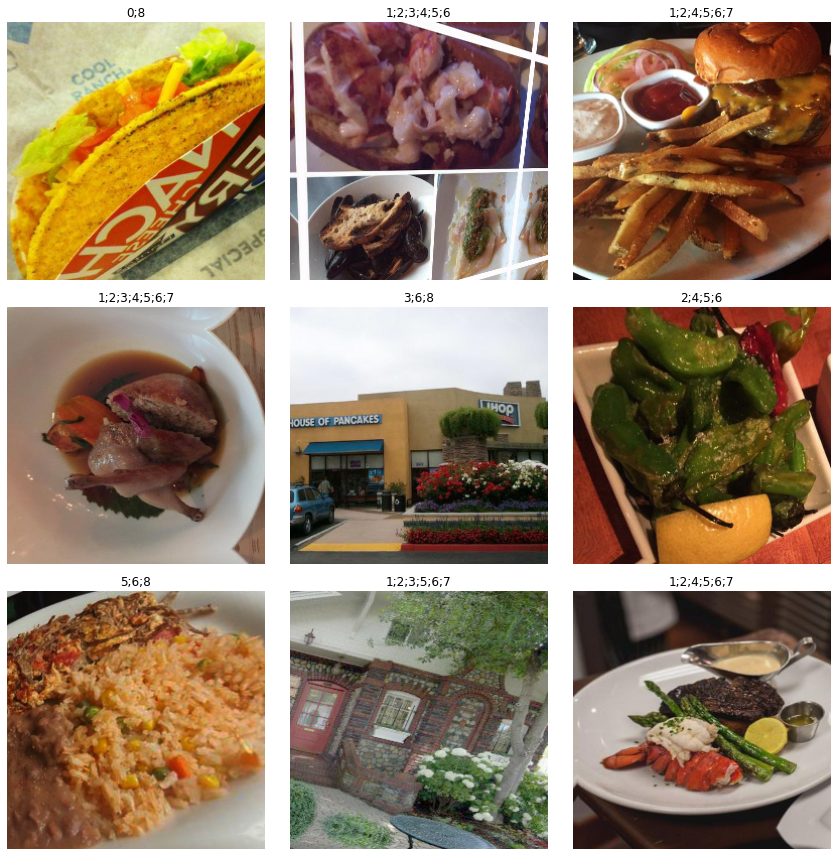

In [24]:
data.show_batch(rows=3)

# Métricas.
## Debemos Revisar qué es lo que miden en el concurso.

Miden el F1 score, que es la medai armónica entre precisión y recall. Para cada restaurante nos preguntan si tiene tal propiedad... debemos decir "sí" o "no"

La red regresa un número entre 0 y 1 que indica qué tanto "cree" que sea verdad cierta propiedad. Buscaremos el threshold óptimo para hacer las predicciones

In [25]:
fai.beta?

Object `fai.beta` not found.


Hay que encontrar el mejor threshold para todas las batches al mismo tiempo. Para cada threshold calcular el promedio y tomar el máximo de los promedios

In [41]:
def fbeta_noreduce(y_pred, y_targ, thresh, beta=1.):
  eps = 1e-8
  beta2 = beta*beta
  y_pred = (y_pred.sigmoid() > thresh).float()
  y_targ = y_targ.float()
  TP = (y_pred*y_targ).sum(dim=1)
  prec = TP/(y_pred.sum(dim=1)+eps)
  rec = TP /(y_targ.sum(dim=1)+eps)
  res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
  return (res)

In [43]:
class BestF1(fai.Callback):
  def on_epoch_begin(self, threshes = np.linspace(0.0,1.0,41), **kwargs):
    self.threshes = threshes

    self.memory = torch.zeros((len(threshes),0))
    #Memory es un matriz donde cada renglón es una threshod diferente

    self.best_threshes = 0.5
    self.best_score = 0.0

  def on_batch_end(self, last_output, last_target, **kwargs):
    tries = torch.stack([fbeta_noreduce(last_output,last_target,thresh=t) for t in self.threshes]).cpu()
    
    slef.memory = torch.cat((self.memory, tries),dim=1) 

  def on_epoch_ends(self, last_metrics, **kwargs):
    scores = torch.mean(self.memory, dim=1)
    best_idx = torch.argmax(scores, dim=0)
    self.best_thresh = self.threshes[best_idx.item()]
    self.best_score = scores[best_idx]

    self.memory = torch.zeros((len(self.threshes),0))

    return (fai.add_metrics(last_metrics, self.best_score))

In [44]:
class F1_Score:
  def __init__(self,thresh:float):
    self.thresh = thresh
  def __call__(self, inp, targ):
    return (fai.fbeta(inp, targ, thresh=self.thresh, beta=1.))
  def __repr__(self):
    return (f"F1({self.thresh})")
  @property
  def __name__(self):
    return (self.__repr__())

In [45]:
best_f1 = BestF1()
metrics = [F1_Score(t) for t in [0.3,0.4,0.5,0.6,0.7]] + [best_f1]

Hay que tener cuidado, estas métricas son POR IMAGEN, no por negocio (que es lo que miden en el concurso), así que los restaurantes con muchas fotos están sobre representados. Por otro lado, después combinaremos información de varias fotos para llegar a scores más altos

# Learner

In [46]:
learn = fv.cnn_learner(data, fv.models.resnet50, metrics=metrics, opt_func=XRanger)

Cuando hacemos un cnnn learner todo empieza congelado, excepto la última capa

In [47]:
len(learn.layer_groups)

3

In [48]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
___________________________________________________

epoch,train_loss,valid_loss,F1(0.3),F1(0.4),F1(0.5),F1(0.6),F1(0.7),best_f1,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


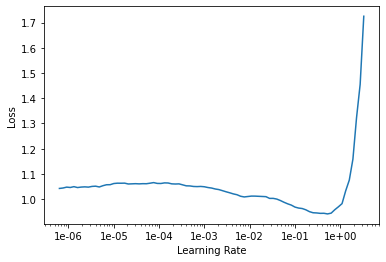

In [49]:
learn.lr_find();learn.recorder.plot()

In [1]:
learn.fit_one_cycle(5,1e-2, div_factor=1.0, final_div=200)

NameError: ignored

In [ ]:
print(f'Mejor threshold: {best_f1.best_threshold} con f1 de {best_f1,best_score}')

Estamos usando una foto para decidir sobre el restaurant... Vamos a usar más fotos

In [ ]:
learn.save(f'stage1-r50_'{best_f1.best_score:.4f})

In [ ]:
learn.freeze_to(-2)

In [ ]:
learn.fit_one_cycle(8,slice(3e-3),div_factor=0.9, final_div=100,pct_start=0.7)

In [ ]:
print(f'Mejor threshold: {best_f1.best_threshold} con f1 de {best_f1,best_score}') 

Ahora que hemos entrenad, falta combinar varias imágenes para un mismo negocio. ¿Cómo hacemos eso? Recuerden que las redes neuronales toman input de tamaño FIJO, no variable. Podriamos usar redes recurrentes (parta tamaño variable), pero eso sólo serviría si estuvierna en órden las imágenes, que no lo están.

_Algunos restaurantes pueden tener 100 imágenes, otros 500 imágenes_

Hay varias maneras. Aquí se propone una que no se ha usado hace mucho... Extraer información estadística sobre lo que escupe la red neuronal y después hacemos lo siguiente!

# Creamos stats para cada negocio

In [ ]:
def stacked_deductions(model, biz_id, bs = 64):
  gc.collect()
  tmfs = Img2Tensor(IMG_SIZE)
  img_names = ['train_photos/'+str(name)+'.jpg' for name in img_names]
  lbls = [0]*len(img_names)

  DS = ImgDataset(img_names, lbls, tfms)
  DL = DataLoader(DS, btach_size=bs, shuffle=False, num_workers=8)

  #Crea un DataLoader para pasar por el modelo, pasa por el modelo, las concatena y las agrega a algo de numpy
  result = []
  for img, lb in DL:
    D = model(imgs.cuda()).cpu().numpy()
    result.append(D)

  return (np.concatenate(result, axis=0))

In [ ]:
#limpiar memoria
gc.collect()

In [ ]:
# Modo evaluación y quitar lo gradientes para que sea más rápido
model = learn.model.eval()
for p in model.parameters():
  p.requires_grad = False

In [ ]:
Dataset??

Para cada negocio, creamos una matriz de num_photos x 9
===>
Pasamos aun arreglo de _ x 1

In [ ]:
#Agregar toda la información a un arreglo y después con una Red Neuronal Recurrente 
# deduzca la verdad a partir de la distibución de probabilidad
def get_features_from_array(array):
  #El numero de fotos
  result = [np.array(array.shape[0]/100)[None]]
  result += [np.mean(array, axis=0)]
  result += [np.percentile(array, q, axis=0) for q in np.linspace(0,100,11)]
  result += [np.std(array, axis=0)]

  result += [np.corrcoef(array.transpose()).flatten()]
  return( np.concatenate(result, axis=0) )

In [ ]:
def one_hot(label):
  A = torch.zeros((9,))
  for l in label.split():
    A[int(l)] = l
    return A

In [ ]:

def get_features(biz):
  return( get_features_from_array(stacked_deductions(model,biz)) )

In [ ]:
all_bizzes = list(biz2photos.keys())

In [ ]:
len(all_bizzes)

In [ ]:
gc.collect()

In [ ]:
get_features(1000).shape

In [ ]:
 biz2features = {biz:get_features(biz) for biz in progress_bar(all_bizzes)}

NameError: ignored

In [ ]:
gc.collect()

In [ ]:
len(biz2features[3])

In [ ]:
print(DONE!)

In [ ]:
torch.save(biz2features,"biz2features.dict")

Listo! Ahora pasamos a la libreta _02.Yelp.TabularPart.ipynb_